# Titanic Survival Prediction

### *Business Goal: Build a model to predict if a passenger will survive on the titanic disaster*

## Import packages/libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

## Get and load the data

In [2]:
train = pd.read_csv('../data/train.csv', sep=',')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.shape

(891, 12)

# Exploratory Data Analysis

## Survived

* the number of survived/non-survived passengers . Approximately 38% of people was survived in train data*

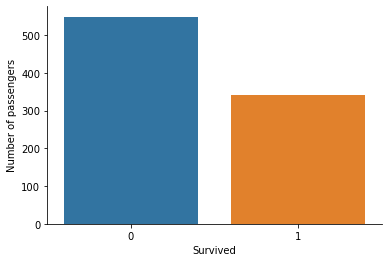

In [4]:
sns.countplot(x='Survived', data=train)
plt.ylabel('Number of passengers')
sns.despine()

## Age

* *In terms of age, the distribution is normal. If there is a missing value, the mean value group by male/female could be used.*

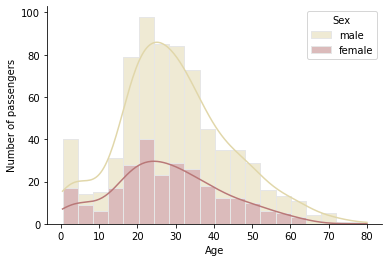

In [5]:
sns.histplot(
    train,
    x='Age', hue='Sex',
    multiple='stack',
    palette='pink_r',
    edgecolor='.9',
    linewidth=1,
    kde = True
)
plt.ylabel('Number of passengers')
sns.despine()

* *In 20-30 age ranges, male survived chance is high; on the other side, in 15-40 age ranges, female survived chance is high. Therefore we would use ages in a scale*

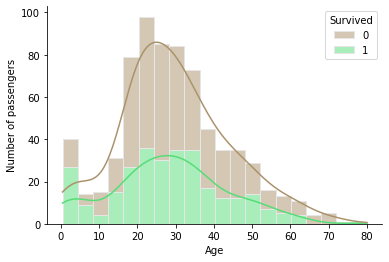

In [6]:
sns.histplot(train,
            x = 'Age',hue = 'Survived',
            multiple='stack',
            palette='terrain_r',
            edgecolor='.9',
            linewidth=1,
            kde=True)
plt.ylabel('Number of passengers')
sns.despine()

## Embarked

* *Embarked seems to be correlated with survival, depending on the gender.*

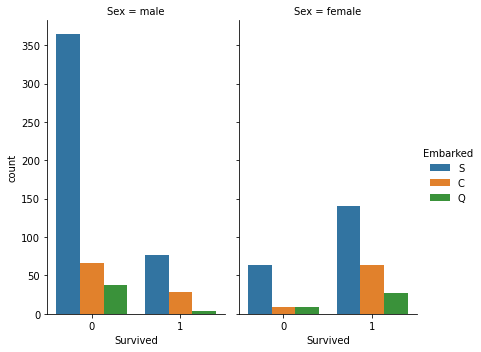

In [7]:
sns.catplot(x='Survived',  hue='Embarked', col='Sex',
                data=train, kind='count',
                height=5, aspect=.6) 
sns.despine()


## Pclass

* *Pclass also seems to be correlated with survival*

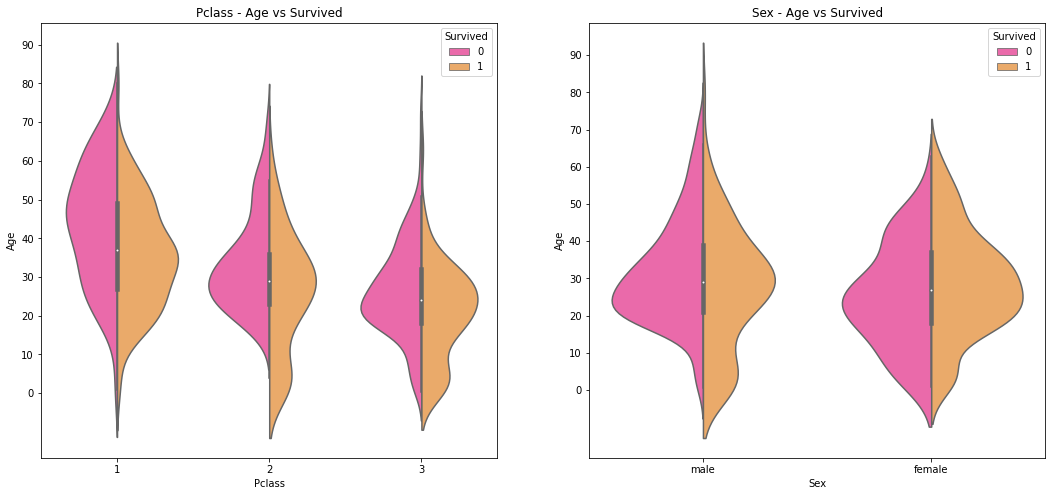

In [8]:
f,ax = plt.subplots(1, 2, figsize = (18, 8))
sns.violinplot('Pclass', 'Age', hue = 'Survived', data = train, split = True, ax = ax[0], palette = 'spring')
ax[0].set_title('Pclass - Age vs Survived')
ax[0].set_yticks(range(0, 100, 10))
sns.violinplot('Sex', 'Age', hue = 'Survived', data = train, split = True, ax = ax[1], palette = 'spring')
ax[1].set_title('Sex - Age vs Survived')
ax[1].set_yticks(range(0, 100, 10))

plt.show()

* *From the left graph, most of dead are in Pclass 3. From the right graph, we found that females survived more than males*

## Fare

* *At low prices survived chance is high; on the other side, while price is increasing, the survived chance will be low. Therefore we would use fare in a logical scale*

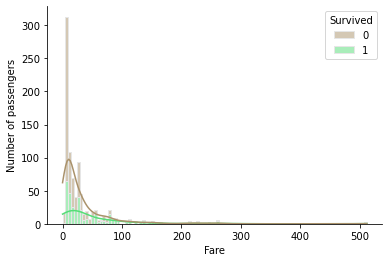

In [9]:
sns.histplot(train,
            x = 'Fare',hue = 'Survived',
            multiple='stack',
            palette='terrain_r',
            edgecolor='.9',
            linewidth=1,
            kde=True)
plt.ylabel('Number of passengers')
sns.despine()

## Check whether the column is binary, categorical or metric.

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* *We need to convert the features into numeric ones. The training-set has 891 examples and 11 features + the target variable (survived). 2 of the features are floats, 5 are integers and 5 are objects.*


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
# Getting the Categorical and Numerical Features
train['Pclass'].dtypes, train['Sex'].dtypes

(dtype('int64'), dtype('O'))

In [13]:
numerical_features = [x for x in train.columns if train[x].dtypes != 'O']
categorical_features = [x for x in train.columns if train[x].dtypes == 'O']

In [14]:
numerical_features, categorical_features

(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

## Check whether the column contains any missing values.

<AxesSubplot:>

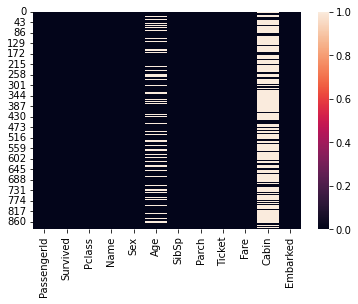

In [15]:
sns.heatmap(train.isnull())

* *From above heatmap, we can see that there are NULL/NaN values present in the dataset. On the below, here are the number of null values Before we start with the Analysis, we need to process this data and then proceed with the analysis*
* *The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but probably I want to drop it from the dataset, since 77 % of it are missing.*

In [16]:
train.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Name, Passenger ID & Ticket

* *Name, PassengerID and Ticket are not important columns and they do not contribute to a high survival rate that's why it could be dropped*

In [17]:
train.drop(['Name'],axis = 1, inplace = True)
categorical_features.remove('Name')

In [18]:
train.drop(['PassengerId'], axis = 1, inplace = True)
numerical_features.remove('PassengerId')

In [19]:
train.drop(['Ticket'], axis = 1, inplace = True)
categorical_features.remove('Ticket')

### Cabin

* *Cabin column has more null values and there are so many unique values that's why I dropped it*

In [20]:
train[['Cabin']].describe()

,Cabin
count,204
unique,147
top,B96 B98
freq,4


In [21]:
train.drop(['Cabin'],axis = 1,inplace = True)
categorical_features.remove('Cabin')

In [22]:
numerical_features, categorical_features

(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], ['Sex', 'Embarked'])

### Age & Sex

* *The below histogram clears that the data is normally distributed, and so we would be using mean for NULL values*

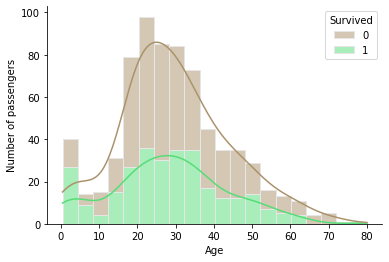

In [23]:
sns.histplot(train,
            x = 'Age',hue = 'Survived',
            multiple='stack',
            palette='terrain_r',
            edgecolor='.9',
            linewidth=1,
            kde=True)
plt.ylabel('Number of passengers')
sns.despine()


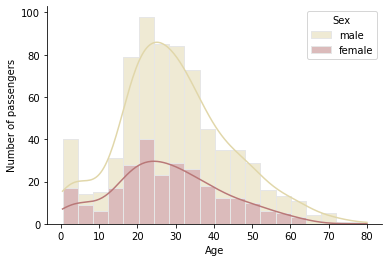

In [24]:
sns.histplot(
    train,
    x='Age', hue='Sex',
    multiple='stack',
    palette='pink_r',
    edgecolor='.9',
    linewidth=1,
    kde = True
)
plt.ylabel('Number of passengers')
sns.despine()


* *I applied mean value of age by Sex(male/female passengers)*

In [25]:
train['Age'] = train['Age'].fillna(train.groupby(['Sex'])['Age'].transform('mean'))
train.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q


In [26]:
train['Age'].isna().sum()

0

### Embarked

* *Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)*

In [27]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [28]:
train['Embarked'].fillna('S', inplace=True)

In [29]:
train['Embarked'].describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

# Feature Engineering

### Age

* *I appied it divided by 5 age groups. *


In [30]:
train['Age'].describe()

count    891.000000
mean      29.736034
std       13.014897
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [31]:
kbins = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')

In [32]:
columns_age = train[['Age']]

In [33]:
kbins.fit(columns_age)

KBinsDiscretizer(encode='onehot-dense')

In [34]:
t_age = kbins.transform(columns_age)
t_age.shape

(891, 5)

In [35]:
edges_age = kbins.bin_edges_[0].round(4)
edges_age

array([ 0.42  , 20.    , 27.9157, 30.7266, 38.    , 80.    ])

In [36]:
labels_age = []
for i in range(len(edges_age)-1):
    edge1 = edges_age[i]
    edge2 = edges_age[i+1]
    labels_age.append(f"{edge1}_to_{edge2}")

# create a DataFrame
Age_t = pd.DataFrame(t_age, columns=labels_age)
Age_t.head()

,0.42_to_20.0,20.0_to_27.9157,27.9157_to_30.7266,30.7266_to_38.0,38.0_to_80.0
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


### Sex

In [37]:
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [38]:
cols_sex = train[['Sex']]

In [39]:
ohc.fit(cols_sex)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [40]:
t_sex = ohc.transform(cols_sex)
t_sex.shape

(891, 2)

In [41]:
Sex_t = pd.DataFrame(t_sex, columns=ohc.get_feature_names())
Sex_t.head()

,x0_female,x0_male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [42]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Embarked

* *Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)*

In [43]:
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [44]:
cols_embarked = train[['Embarked']]

In [45]:
ohc.fit(cols_embarked)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [46]:
t_embarked = ohc.transform(cols_embarked)
t_embarked.shape

(891, 3)

In [47]:
Embarked_t = pd.DataFrame(t_embarked, columns=ohc.get_feature_names())
Embarked_t.head()

,x0_C,x0_Q,x0_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


### Fare

* *Passenger fare (British pound)*
* *I appied it divided by 4 fare groups.*

In [48]:
kbins = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')

In [49]:
columns_fare = train[['Fare']]

In [50]:
kbins.fit(columns_fare)

KBinsDiscretizer(encode='onehot-dense', n_bins=4)

In [51]:
t_fare = kbins.transform(columns_fare)
t_fare.shape

(891, 4)

In [52]:
edges_fare = kbins.bin_edges_[0].round(4)
edges_fare

array([  0.    ,   7.9104,  14.4542,  31.    , 512.3292])

In [53]:
labels_fare = []
for i in range(len(edges_fare)-1):
    edge1 = edges_fare[i]
    edge2 = edges_fare[i+1]
    labels_fare.append(f"{edge1}_to_{edge2}")

# create a DataFrame
Fare_t = pd.DataFrame(t_fare, columns=labels_fare)
Fare_t.head()

,0.0_to_7.9104,7.9104_to_14.4542,14.4542_to_31.0,31.0_to_512.3292
0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0


### SibSp & Parch

* *sibsp: Number of siblings/spouses aboard*
* *parch: Number of parents/children aboard*
* *I created a new column 'Alone' and then if one of them is greater than 1 write 0; otherwise write 1*

In [54]:
train['SibSp_Parch']=train['SibSp']+train['Parch']+1 #1 is person him/herself

In [55]:
train['Alone']=0
train.loc[train.SibSp_Parch==1, 'Alone'] = 1

In [56]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SibSp_Parch,Alone
0,0,3,male,22.0,1,0,7.2500,S,2,0
1,1,1,female,38.0,1,0,71.2833,C,2,0
2,1,3,female,26.0,0,0,7.9250,S,1,1
3,1,1,female,35.0,1,0,53.1000,S,2,0
4,0,3,male,35.0,0,0,8.0500,S,1,1


# Transforming the train data 

In [57]:
train=pd.concat([train, Age_t, Sex_t, Embarked_t, Fare_t], axis=1)

In [58]:
train.drop(['Sex', 'Age', 'Embarked', 'SibSp','Parch', 'SibSp_Parch', 'Fare' ], axis=1, inplace=True)

In [59]:
train.head()

,Survived,Pclass,Alone,0.42_to_20.0,20.0_to_27.9157,27.9157_to_30.7266,30.7266_to_38.0,38.0_to_80.0,x0_female,x0_male,x0_C,x0_Q,x0_S,0.0_to_7.9104,7.9104_to_14.4542,14.4542_to_31.0,31.0_to_512.3292
0,0,3,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,3,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,1,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,3,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [60]:
train.shape

(891, 17)

## Define X, y

In [61]:
X=train.drop('Survived', axis=1)
y=train['Survived']

In [62]:
X.shape, y.shape

((891, 16), (891,))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 16), (179, 16), (712,), (179,))

In [65]:
X_train.head()

,Pclass,Alone,0.42_to_20.0,20.0_to_27.9157,27.9157_to_30.7266,30.7266_to_38.0,38.0_to_80.0,x0_female,x0_male,x0_C,x0_Q,x0_S,0.0_to_7.9104,7.9104_to_14.4542,14.4542_to_31.0,31.0_to_512.3292
807,3,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
318,1,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
530,2,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
535,2,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
231,3,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [66]:
X_test.head()

,Pclass,Alone,0.42_to_20.0,20.0_to_27.9157,27.9157_to_30.7266,30.7266_to_38.0,38.0_to_80.0,x0_female,x0_male,x0_C,x0_Q,x0_S,0.0_to_7.9104,7.9104_to_14.4542,14.4542_to_31.0,31.0_to_512.3292
86,3,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
49,3,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
491,3,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
360,3,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
825,3,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# Logistic Regression model

### Train data

In [67]:
log_reg = LogisticRegression(max_iter=10000)

In [68]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [69]:
round(log_reg.score(X_train, y_train),3)


0.799

In [70]:
pred_log_train = log_reg.predict(X_train)

In [71]:
acc_log_train=round(accuracy_score(y_train, pred_log_train),3)
acc_log_train

0.799

# Classifier Evaluating

### Precision vs recall 

In [72]:
pre_log_train=round(precision_score(y_train, pred_log_train),3)
pre_log_train

0.761

In [73]:
recall_log_train=round(recall_score(y_train, pred_log_train),3)
recall_log_train

0.709

### F1 Score

In [74]:
f_1_log_train=round(f1_score(y_train, pred_log_train),3)
f_1_log_train

0.734

### Confusion Matrix

In [75]:
conf = confusion_matrix(y_train, pred_log_train)
conf

array([[372,  62],
       [ 81, 197]], dtype=int64)

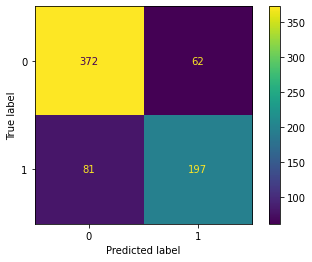

In [76]:
plot_confusion_matrix(log_reg, X_train, y_train, normalize=None)

In [77]:
%matplotlib inline

def plot_heatmap(confusion):
    
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion,
                xticklabels = np.unique(y),
                yticklabels = np.unique(y),
                cmap = 'BuPu',
                annot=True,
                fmt='g'
                )

    # fmt is used to switch off scientific notation
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize = 14)

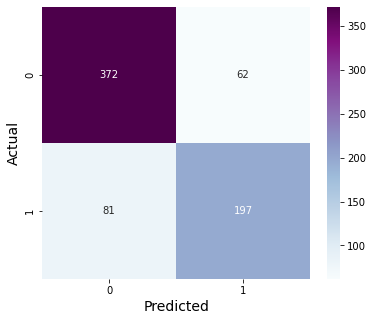

In [78]:
plot_heatmap(conf)

### Test Data

In [79]:
round(log_reg.score(X_test, y_test),3)

0.793

In [80]:
pred_log = log_reg.predict(X_test)

In [81]:
acc_log_test = round(accuracy_score(y_test, pred_log),3)
acc_log_test

0.793

### Kaggle Test Data

In [82]:
X_test_kaggle=pd.read_csv('../data/test_1.csv',sep=',').drop('Survived', axis=1)

In [83]:
X_test_kaggle

,Pclass,Alone,0.17_to_21.0,21.0_to_27.8,27.8_to_30.2727,30.2727_to_39.0,39.0_to_76.0,x0_female,x0_male,x0_C,x0_Q,x0_S,0.0_to_7.8958,7.8958_to_14.4542,14.4542_to_31.5,31.5_to_512.3292
0,3,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0
1,3,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0
2,2,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0
3,3,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
4,3,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
414,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1
415,3,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0
416,3,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0


In [84]:
pred_log_kaggle = log_reg.predict(X_test_kaggle)

In [85]:
pred_log_kaggle_df=pd.DataFrame(pred_log_kaggle, columns=['Survived'])

In [86]:
pred_log_kaggle_df

,Survived
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [87]:
sub_full=pd.read_csv('../data/test.csv',sep=',')

In [88]:
sub_pID=sub_full['PassengerId']

In [89]:
submission=pd.concat([sub_pID,pred_log_kaggle_df], axis=1)

In [90]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [91]:
submission.to_csv('../data/submission.csv', index=0)

# Random Forest 

In [92]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=4)

### Train data

In [93]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [94]:
round(random_forest.score(X_train, y_train),3)

0.822

In [95]:
pred_ran_train = random_forest.predict(X_train)
pred_ran_train

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,

In [96]:
acc_ran_train = round(accuracy_score(y_train, pred_ran_train),3)
acc_ran_train

0.822

In [97]:
pre_ran_train=round(precision_score(y_train, pred_ran_train),3)
pre_ran_train

0.845

In [98]:
recall_ran_train=round(recall_score(y_train, pred_ran_train),3)
recall_ran_train

0.665

In [99]:
f_1_ran_train=round(f1_score(y_train, pred_ran_train),3)
f_1_ran_train

0.744

### Test data

In [100]:
random_forest.fit(X_test, y_test)

RandomForestClassifier(max_depth=4)

In [101]:
round(random_forest.score(X_test, y_test),3)

0.838

In [102]:
pred_ran_test = random_forest.predict(X_test)
pred_ran_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0], dtype=int64)

In [103]:
acc_ran_test = round(accuracy_score(y_test, pred_ran_test),3)
acc_ran_test

0.838

# Decision Tree

In [104]:
dec_tree = DecisionTreeClassifier(max_depth=3)

### Train Data

In [105]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [106]:
round(dec_tree.score(X_train, y_train),3)

0.816

In [107]:
pred_dec_train = dec_tree.predict(X_train)
pred_dec_train

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [108]:
acc_dec_train = round(accuracy_score(y_train, pred_dec_train),3)
acc_dec_train

0.816

In [109]:
pre_dec_train=round(precision_score(y_train, pred_dec_train),3)
pre_dec_train

0.902

In [110]:
recall_dec_train=round(recall_score(y_train, pred_dec_train),3)
recall_dec_train

0.594

In [111]:
f_1_dec_train=round(f1_score(y_train, pred_dec_train),3)
f_1_dec_train

0.716

### Plot the tree

### Test Data

In [112]:
dec_tree.fit(X_test, y_test)

DecisionTreeClassifier(max_depth=3)

In [113]:
round(dec_tree.score(X_test, y_test),3)

0.816

# Cross Validation

In [114]:
cross_accuracy_log = cross_val_score (log_reg,  X_train, y_train,  cv = 5 ,scoring = 'accuracy')

In [115]:
cross_accuracy_ran = cross_val_score (random_forest,  X_train, y_train,  cv = 5 ,scoring = 'accuracy')

In [116]:
cross_accuracy_dec = cross_val_score (dec_tree,  X_train, y_train,  cv = 5 ,scoring = 'accuracy')

In [117]:
mean_log=round(cross_accuracy_log.mean(),3)

In [118]:
mean_ran=round(cross_accuracy_ran.mean(),3) 

In [119]:
mean_dec=round(cross_accuracy_dec.mean(),3)

# Which is the best model ?

In [120]:
results = pd.DataFrame({
    'Model': [ 'Logistic Regression', 
              'Random Forest', 'Decision Tree'],
    'Accuracy': [acc_log_train, acc_ran_train, acc_dec_train],

    'Precision':[pre_log_train, pre_ran_train, pre_dec_train],
    'Recall': [recall_log_train,recall_ran_train, recall_dec_train ],
    'F-1 Score':[f_1_log_train, f_1_ran_train, f_1_dec_train],
    'Cross Accuracy':[mean_log, mean_ran, mean_dec]}
)
result_train = results.sort_values(by='Accuracy', ascending=False)
result_train = result_train.set_index('Model')
result_train.head()

,Accuracy,Precision,Recall,F-1 Score,Cross Accuracy
Model,,,,,
Random Forest,0.822,0.845,0.665,0.744,0.808
Decision Tree,0.816,0.902,0.594,0.716,0.810
Logistic Regression,0.799,0.761,0.709,0.734,0.789
